In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import datetime

2024-03-23 17:17:27.434869: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 17:17:29.466600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/miniconda3/envs/tf/lib
2024-03-23 17:17:29.466700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/user/miniconda3/envs/tf/lib
2024-03-23 17:17:29.466707: W tensorflow/compiler/tf2tensorrt/

In [2]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [3]:
tf.random.set_seed(1337)
ds_folder = "garbage_classification"
image_size = (224, 224)
IMG_SIZE = 224
batch_size = 32
BATCH_SIZE = batch_size

In [4]:
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    directory = f"{ds_folder}",
    labels = "inferred",
    color_mode = "rgb",
    subset="both",
    validation_split=0.2,
    shuffle=True,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Using 3103 files for validation.


2024-03-23 17:17:42.437806: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 17:17:42.490745: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 17:17:42.490844: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-23 17:17:42.511186: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

In [5]:
class_names = train_ds.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

In [7]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


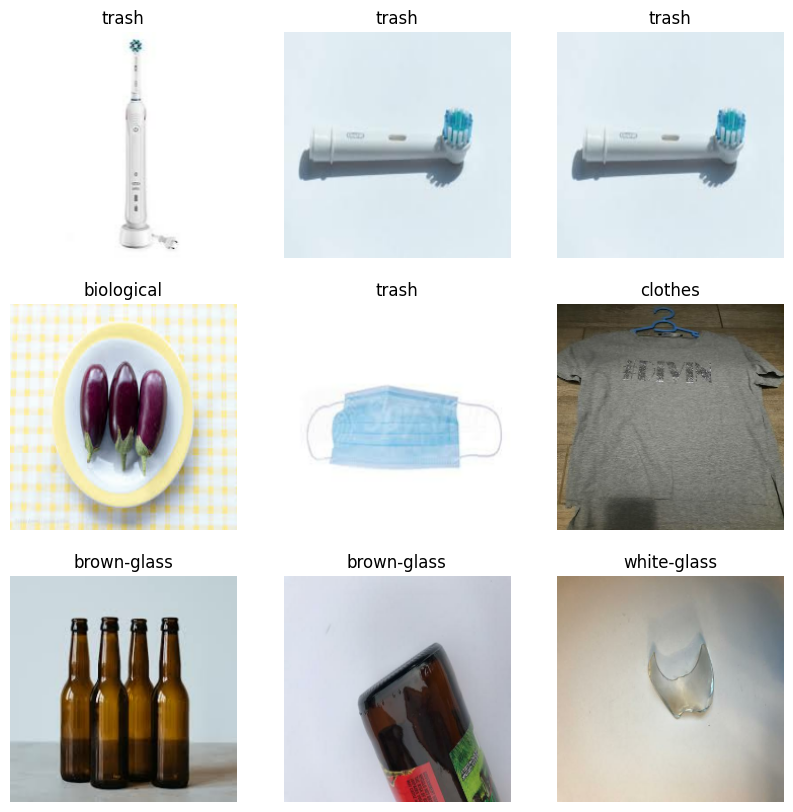

In [8]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
    indexes = []
    for _ in range(9):
        indexes.append(random.randint(0, batch_size-1))
    for i, ind in enumerate(indexes):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(np.array(images[ind]).astype("uint8"))
        plt.title(class_names[int(labels[ind])])
        plt.axis("off")

### Data aug

In [6]:
for folder in os.listdir(f"./{ds_folder}"):
    # file_count = len([name for name in os.listdir(f'./garbage_classification/{folder}') if os.path.isfile(name)])
    file_count = len(os.listdir(f'./garbage_classification/{folder}'))
    print(f'{folder} class count: {file_count}')

battery class count: 945
biological class count: 985
brown-glass class count: 607
cardboard class count: 891
clothes class count: 5325
green-glass class count: 629
metal class count: 769
paper class count: 1050
plastic class count: 865
shoes class count: 1977
trash class count: 697
white-glass class count: 775


In [7]:
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomFlip("vertical"),
    layers.RandomBrightness(factor=0.1),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

In [8]:
# Apply `data_augmentation` to the training images.
train_ds_aug = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds_aug = train_ds_aug.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [28]:
num_classes = len(class_names)

In [189]:
model_small = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes),
    layers.Softmax()
],
name = 'model_small')

In [212]:
tf.version.VERSION

'2.11.1'

In [213]:
# metrics = [
#     tf.keras.metrics.Accuracy(name='accuracy'),
#     # tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
#     # tf.keras.metrics.CategoricalCrossentropy(
#     #     name='categorical_crossentropy',
#     #     dtype=None,
#     #     from_logits=False,
#     #     label_smoothing=0,
#     #     axis=-1
#     # ),
#     tf.keras.metrics.F1Score(
#         average=None, threshold=None, name='f1_score', dtype=None
#     ),
#     # tf.keras.metrics.FalseNegatives(
#     #     thresholds=None, name=None, dtype=None
#     # ),
#     # tf.keras.metrics.FalsePositives(
#     #     thresholds=None, name=None, dtype=None
#     # ),
#     # tf.keras.metrics.Precision(
#     #     thresholds=None, top_k=None, class_id=None, name=None, dtype=None
#     # ),
#     # tf.keras.metrics.Recall(
#     #     thresholds=None, top_k=None, class_id=None, name=None, dtype=None
#     # )
# ]

### Custom precision and recall metrics?

In [9]:
from tensorflow.keras import backend as K

In [10]:
# def precision(y_true, y_pred):
#     """Precision metric.
#     Only computes a batch-wise average of precision.
#     Computes the precision, a metric for multi-label classification of
#     how many selected items are relevant.
#     """
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
#     precision = true_positives / (predicted_positives + K.epsilon())
#     return precision


# def recall(y_true, y_pred):
#     """Recall metric.
#     Only computes a batch-wise average of recall.
#     Computes the recall, a metric for multi-label classification of
#     how many relevant items are selected.
#     """
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
#     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall

In [11]:
def f1(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
    
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [224]:
model_small.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', f1])

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor = "val_accuracy",
    min_delta = 0.01,
    patience = 5,
    verbose = 0,
    restore_best_weights=True
)

In [13]:
log_dir = "garbage_logs/fit/basic" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [14]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

In [15]:
callbacks = [
    # keras.callbacks.ModelCheckpoint("three_batchnorm_at_{epoch}.keras"),
    tensorboard_callback,
    early_stop
]

In [16]:
epochs = 5

In [230]:
history = model_small.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = callbacks
)

Epoch 1/5
388/388 [==============================] - 19s 45ms/step - loss: 1.4154 - accuracy: 0.5349 - f1: 3.9850 - val_loss: 1.0444 - val_accuracy: 0.6565 - val_f1: 2.6613
Epoch 2/5
388/388 [==============================] - 19s 48ms/step - loss: 0.8875 - accuracy: 0.7054 - f1: 2.3995 - val_loss: 0.9371 - val_accuracy: 0.6977 - val_f1: 2.2701
Epoch 3/5
388/388 [==============================] - 18s 45ms/step - loss: 0.6380 - accuracy: 0.7871 - f1: 1.9273 - val_loss: 1.0641 - val_accuracy: 0.6964 - val_f1: 1.8303
Epoch 4/5
388/388 [==============================] - 17s 45ms/step - loss: 0.4366 - accuracy: 0.8544 - f1: 1.6097 - val_loss: 1.2383 - val_accuracy: 0.7019 - val_f1: 1.5735
Epoch 5/5
388/388 [==============================] - 18s 46ms/step - loss: 0.2772 - accuracy: 0.9082 - f1: 1.3707 - val_loss: 1.5381 - val_accuracy: 0.6977 - val_f1: 1.4160


In [91]:
# history_df = pd.DataFrame(history.history)
# history_df[['loss', 'val_loss']].plot()

In [92]:
# history_df[['accuracy', 'val_accuracy']].plot()

### With data augmentation

In [17]:
log_dir = "garbage_logs/fit/augmented-" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

In [18]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

In [19]:
callbacks = [
    tensorboard_callback,
    early_stop
]

In [20]:
# model_small_aug = tf.keras.models.clone_model(model_small)

In [29]:
model_small_aug = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(filters=64,  kernel_size = 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes),
    layers.Softmax()
],
name = 'model_small_aug')

In [30]:
metrics = [
    tf.keras.metrics.Accuracy(name='accuracy'),
    # tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    # tf.keras.metrics.CategoricalCrossentropy(
    #     name='categorical_crossentropy',
    #     dtype=None,
    #     from_logits=False,
    #     label_smoothing=0,
    #     axis=-1
    # ),
    # tf.keras.metrics.F1Score(
    #     average=None, threshold=None, name='f1_score', dtype=None
    # ),
    # tf.keras.metrics.FalseNegatives(
    #     thresholds=None, name=None, dtype=None
    # ),
    # tf.keras.metrics.FalsePositives(
    #     thresholds=None, name=None, dtype=None
    # ),
    # tf.keras.metrics.Precision(
    #     thresholds=None, top_k=None, class_id=None, name=None, dtype=None
    # ),
    # tf.keras.metrics.Recall(
    #     thresholds=None, top_k=None, class_id=None, name=None, dtype=None
    # )
]


In [31]:
model_small_aug.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy', f1])

In [32]:
for image_batch, labels_batch in val_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

(32, 224, 224, 3)
(32,)
tf.Tensor(
[ 9  9  4  1 11  9  4  1  0  8  4  1  0  6  8  3  0  0  9  7  2  5  1  4
  5  4  2  5  4  8  1  7], shape=(32,), dtype=int32)


In [33]:
for image_batch, labels_batch in train_ds_aug:
    print(image_batch.shape)
    print(labels_batch.shape)
    print(labels_batch)
    break

(32, 224, 224, 3)
(32,)
tf.Tensor(
[ 1  4  4 10 10  4  4  6  0  7  4  2 10  9 10  9  0  4 11  2  3  9  7  6
 10  2 11 10  7  8  5  4], shape=(32,), dtype=int32)


In [34]:
# model_small.summary()

In [35]:
# model_small_aug.summary()

In [36]:
history_aug = model_small_aug.fit(
    train_ds_aug,
    validation_data=val_ds,
    epochs=epochs,
    callbacks = callbacks
)

Epoch 1/5


2024-03-23 17:18:42.736593: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2024-03-23 17:18:44.688018: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-23 17:18:46.408835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-03-23 17:18:46.439949: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x5623cb0cd0b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-23 17:18:46.439981: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-03-23 17:18:46.472276: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-23 17:18:46.76

388/388 [==============================] - ETA: 0s - loss: 1.4713 - accuracy: 0.5055 - f1: 4.1784

2024-03-23 17:19:12.349414: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1329070080 exceeds 10% of free system memory.


388/388 [==============================] - 33s 63ms/step - loss: 1.4713 - accuracy: 0.5055 - f1: 4.1784 - val_loss: 1.4169 - val_accuracy: 0.5169 - val_f1: 3.0757
Epoch 2/5
388/388 [==============================] - ETA: 0s - loss: 1.0731 - accuracy: 0.6416 - f1: 2.8171

2024-03-23 17:19:46.377528: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1329070080 exceeds 10% of free system memory.


388/388 [==============================] - 34s 86ms/step - loss: 1.0731 - accuracy: 0.6416 - f1: 2.8171 - val_loss: 1.2741 - val_accuracy: 0.5775 - val_f1: 2.4656
Epoch 3/5
387/388 [============================>.] - ETA: 0s - loss: 0.9512 - accuracy: 0.6842 - f1: 2.4857

2024-03-23 17:20:13.036697: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1329070080 exceeds 10% of free system memory.


388/388 [==============================] - 26s 66ms/step - loss: 0.9513 - accuracy: 0.6843 - f1: 2.4856 - val_loss: 1.3301 - val_accuracy: 0.5707 - val_f1: 2.3182
Epoch 4/5
388/388 [==============================] - ETA: 0s - loss: 0.8535 - accuracy: 0.7129 - f1: 2.2716

2024-03-23 17:20:38.362659: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1329070080 exceeds 10% of free system memory.


388/388 [==============================] - 25s 63ms/step - loss: 0.8535 - accuracy: 0.7129 - f1: 2.2716 - val_loss: 1.4009 - val_accuracy: 0.5752 - val_f1: 2.2723
Epoch 5/5
388/388 [==============================] - ETA: 0s - loss: 0.8040 - accuracy: 0.7291 - f1: 2.1699

2024-03-23 17:21:03.767497: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1329070080 exceeds 10% of free system memory.


388/388 [==============================] - 25s 63ms/step - loss: 0.8040 - accuracy: 0.7291 - f1: 2.1699 - val_loss: 1.3664 - val_accuracy: 0.5975 - val_f1: 2.1134
